1. LayoutXLM complete
2. LayoutXLM corrupted [0, 0, 0, 0]
3. BERT

In [10]:
import torch.nn as nn
import torch.optim as optim
import torch
import numpy as np

folders = [r'C:\Users\Habram\Documents\thesis-masters\LayouXLM\Custom',
           r'C:\Users\Habram\Documents\thesis-masters\LayouXLM\Custom_zero-positions',
           r'C:\Users\Habram\Documents\thesis-masters\BERT']

models = ['LayoutXLM complete',
          'LayoutXLM corrupted',
          'BERT']

variants = ['real', 'fake', 'hybrid']

label_list = ['other',
              'r_name', 'r_street', 'r_housenumber', 'r_zip', 'r_city', 'r_country',
              's_name', 's_street', 's_housenumber', 's_zip', 's_city', 's_country', 's_bank', 's_iban',
              'i_number','i_date', 'i_amount']

id2label = {0: 'O',
            1: 'B-R_NAME',
            2: 'I-R_NAME',
            3: 'B-R_STREET',
            4: 'I-R_STREET',
            5: 'B-R_HOUSENUMBER',
            6: 'I-R_HOUSENUMBER',
            7: 'B-R_ZIP',
            8: 'I-R_ZIP',
            9: 'B-R_CITY',
            10: 'I-R_CITY',
            11: 'B-R_COUNTRY',
            12: 'I-R_COUNTRY',
            13: 'B-S_NAME',
            14: 'I-S_NAME',
            15: 'B-S_STREET',
            16: 'I-S_STREET',
            17: 'B-S_HOUSENUMBER',
            18: 'I-S_HOUSENUMBER',
            19: 'B-S_ZIP',
            20: 'I-S_ZIP',
            21: 'B-S_CITY',
            22: 'I-S_CITY',
            23: 'B-S_COUNTRY',
            24: 'I-S_COUNTRY',
            25: 'B-S_BANK',
            26: 'I-S_BANK',
            27: 'B-S_IBAN',
            28: 'I-S_IBAN',
            29: 'B-I_NUMBER',
            30: 'I-I_NUMBER',
            31: 'B-I_DATE',
            32: 'I-I_DATE',
            33: 'B-I_AMOUNT',
            34: 'I-I_AMOUNT'
        }

In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(768, 35)

    def forward(self, x):
        x = self.fc(x)
        return x
    
softmax = nn.Softmax(dim=1)

In [12]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class IstvoicesDataset(Dataset):
    def __init__(self, data):
        self.labels = data['labels']
        self.embeddings =  data['embeddings']

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        emb = self.embeddings[idx]
        lab = self.labels[idx]

        return emb, lab

In [13]:
def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label.lower()

def get_all_predictions(classifier, test_dataloader, testing_data):
    all_labels = []
    all_predictions = []
    
    # iterate over the whole test set
    for test_idx in range(len(testing_data['embeddings'])):
        test_features, test_labels = next(iter(test_dataloader))
        predictions = classifier(test_features)
        predictions = softmax(predictions[0])
        predictions = torch.argmax(predictions, dim=1)
        predictions = predictions.numpy()
        test_labels = test_labels[0].numpy()

        # Get the actual labels (str)
        true_predictions = [id2label[pred] for pred, label in zip(predictions, test_labels)]
        true_labels      = [id2label[label] for pred, label in zip(predictions, test_labels)]

        all_labels.append(list(map(iob_to_label, true_labels)))
        all_predictions.append(list(map(iob_to_label, true_predictions)))

    return all_labels, all_predictions

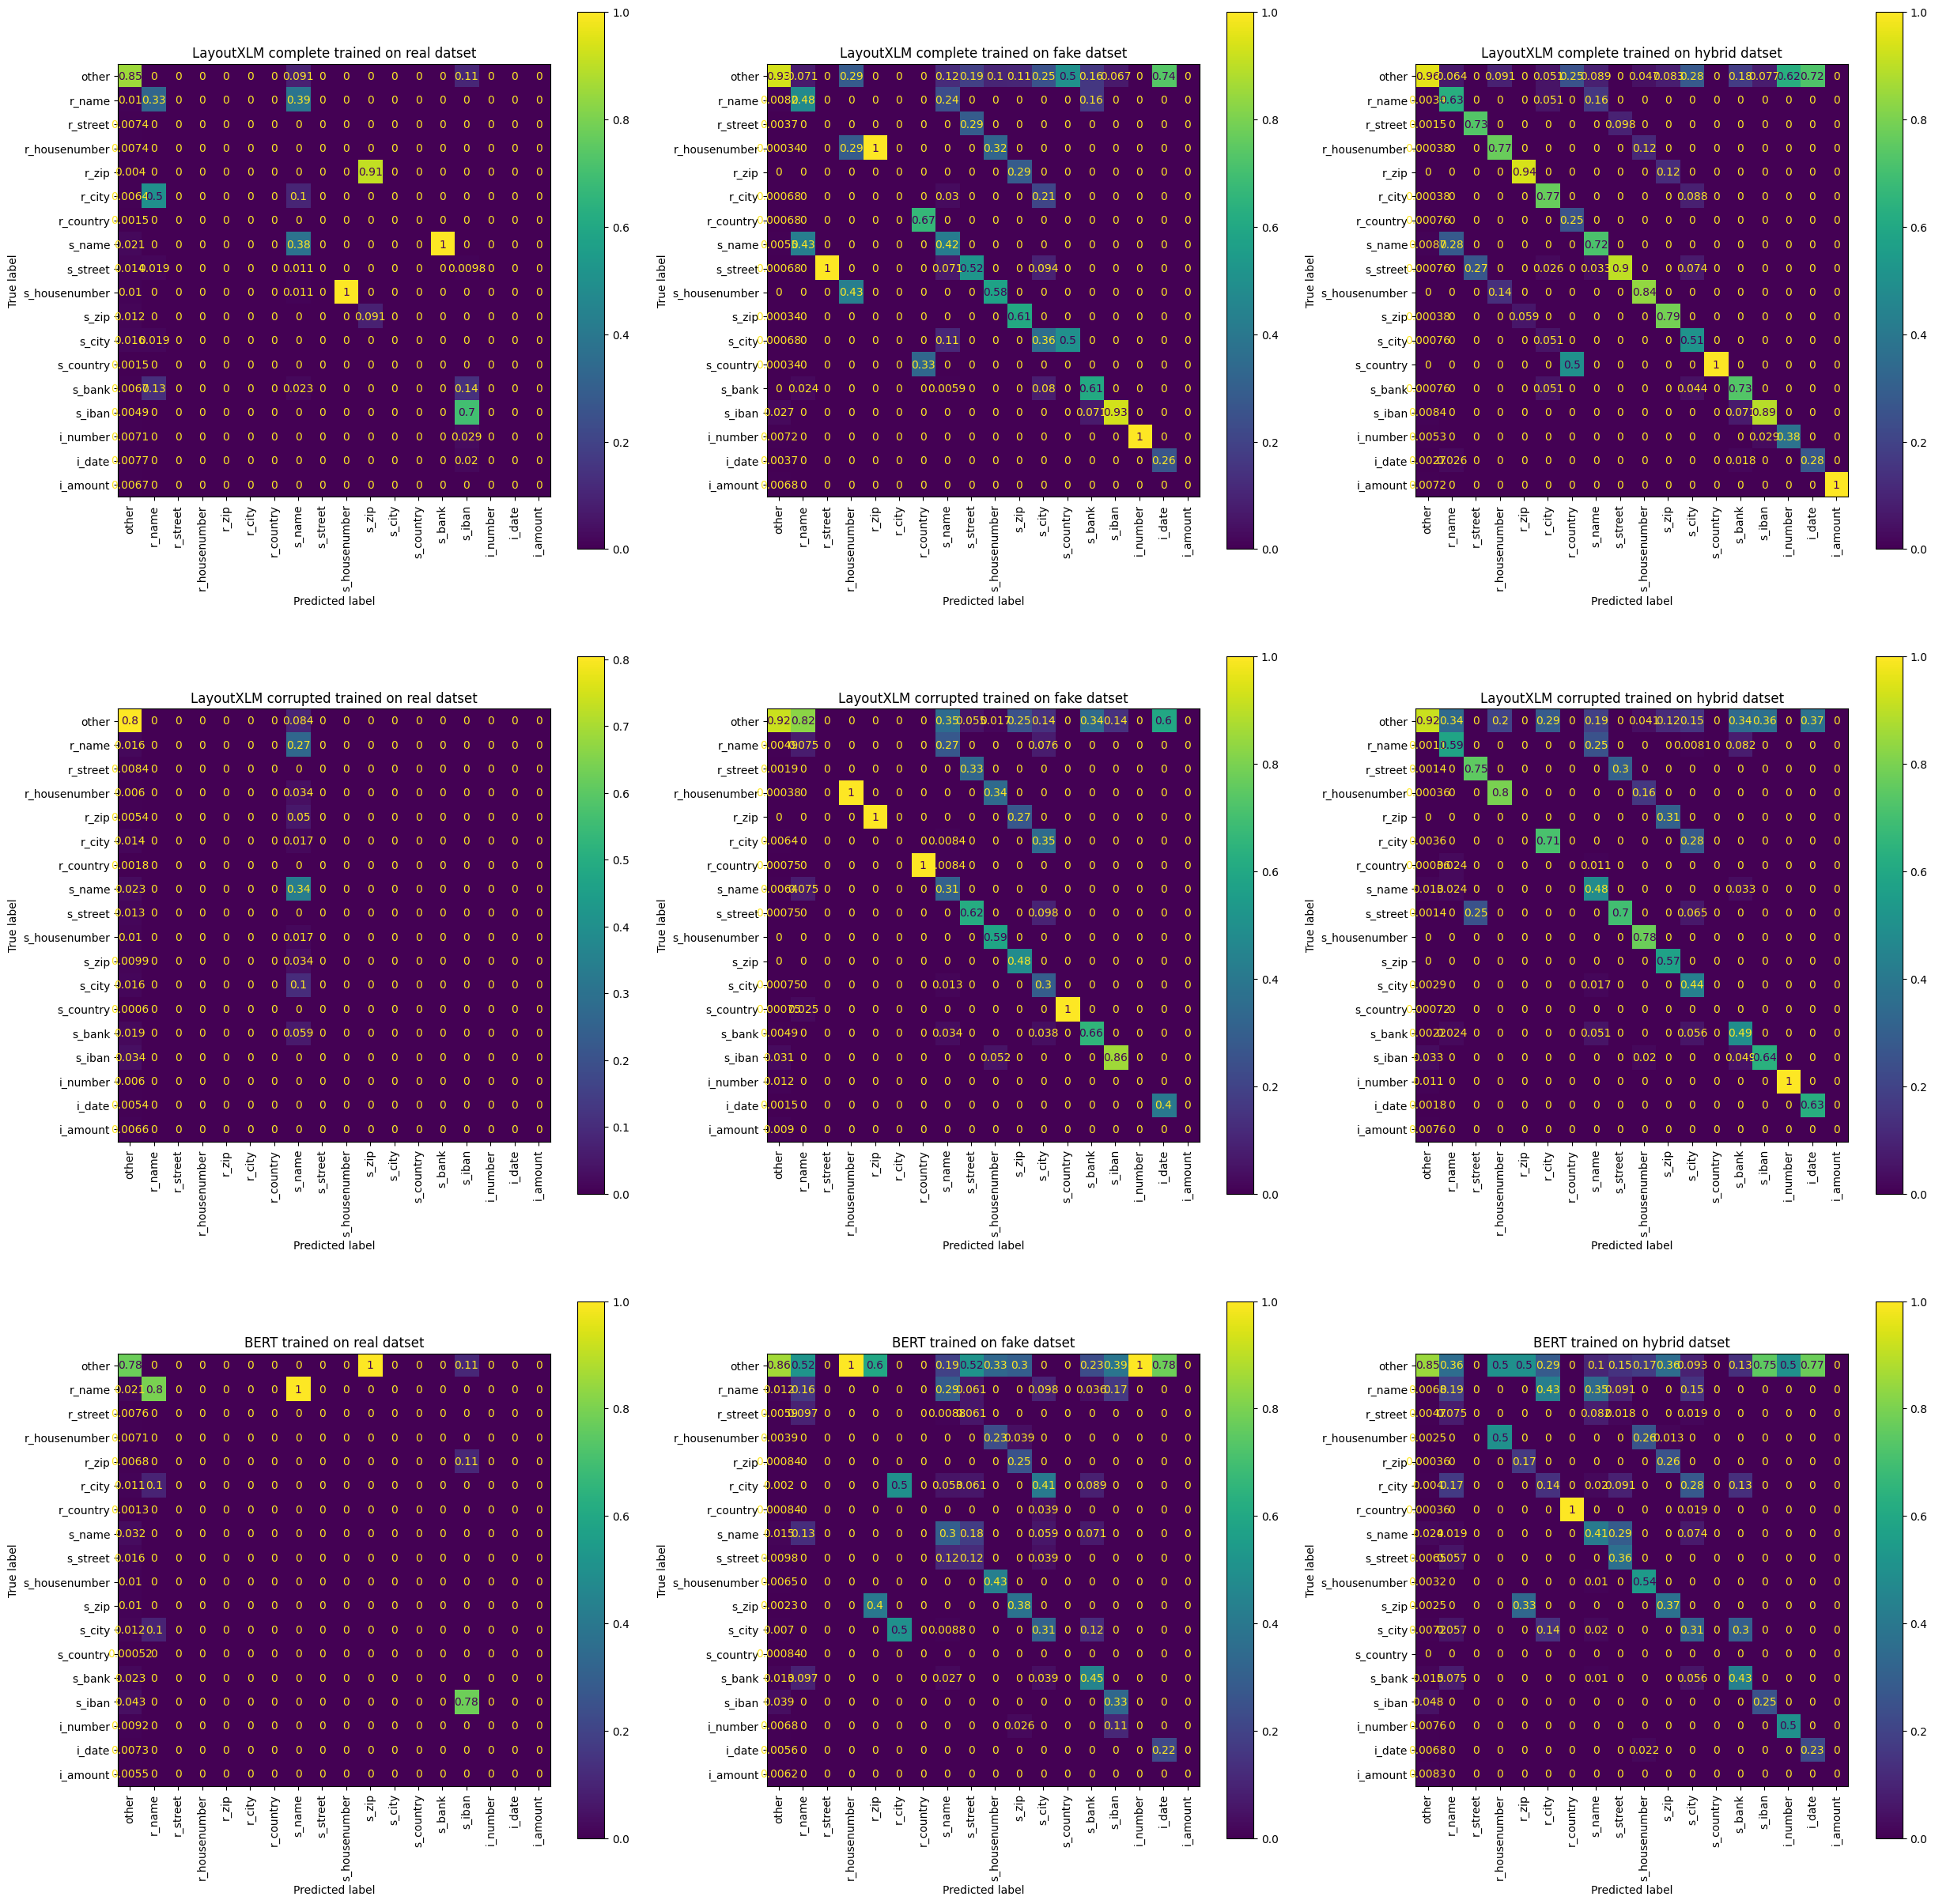

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,3)
fig.set_figheight(30)
fig.set_figwidth(30)

for x, (model, folder) in enumerate(zip(models, folders)):
    for y, variant in enumerate(variants):
        classifier = Net()
        classifier.load_state_dict(torch.load(rf'{folder}/{variant}2real_classifier.pt'))
        testing_data = np.load(rf'{folder}/{variant}2real_test.npy', allow_pickle=True).item()

        dataset_test_torch = IstvoicesDataset(testing_data)
        test_dataloader = DataLoader(dataset_test_torch, batch_size=1, shuffle=True)

        all_labels, all_predictions = get_all_predictions(classifier, test_dataloader, testing_data)

        all_labels = [item.lower() for sublist in all_labels for item in sublist]
        all_predictions = [item.lower() for sublist in all_predictions for item in sublist]

        cm = confusion_matrix(y_true=all_labels, y_pred=all_predictions, labels=label_list, normalize='pred')
        cm_display = ConfusionMatrixDisplay(cm, display_labels=label_list)
        cm_display.plot(ax=axs[x][y], xticks_rotation='vertical')
        axs[x][y].set_title(f'{model} trained on {variant} datset')
plt.show()

### Entity-level metrics

In [6]:
from datasets import load_dataset

label_list = ['Dataset split', 'other',
              'r_name', 'r_street', 'r_housenumber', 'r_zip', 'r_city', 'r_country',
              's_name', 's_street', 's_housenumber', 's_zip', 's_city', 's_country',
              's_bank', 's_iban','i_number','i_date', 'i_amount']
               
variants = ['real_train', 'real_test', 'fake_train', 'fake_test', 'hybrid_train', 'hybrid_test']

label_distribution = {}
for value in variants:
    label_distribution[value] = {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0,
                                 '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0}

c:\Users\Habram\Anaconda3\envs\LayoutXLM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
for variant in variants:
    variant = variant[:variant.index('_')]
    dataset = load_dataset(rf'C:\Users\Habram\Documents\Datasets_final\{variant}2real\{variant}2real.py',
                           cache_dir=rf'C:\Users\Habram\Documents\Datasets_final\{variant}2real')
    
    for split in ['train', 'test']:
        for document in dataset[split]['ner_tags']:
            for entity in document:
                if entity == 0:
                    label_distribution[variant+'_'+split][str(entity)] += 1
                elif entity % 2 == 1:
                    label_distribution[variant+'_'+split][str(int((entity+1)/2))] += 1
        num_documents = len(dataset[split]['ner_tags'])
        for elem in label_distribution[variant+'_'+split]:
            label_distribution[variant+'_'+split][elem] /= num_documents

Found cached dataset real2real (C:/Users/Habram/Documents/Datasets_final/real2real/real2real/default/0.0.0/54f537a651f7b024e451ac4471d95670b047e761ad726ea9c18c00b00d9757ed)
100%|██████████| 2/2 [00:00<00:00, 249.59it/s]
Found cached dataset real2real (C:/Users/Habram/Documents/Datasets_final/real2real/real2real/default/0.0.0/54f537a651f7b024e451ac4471d95670b047e761ad726ea9c18c00b00d9757ed)
100%|██████████| 2/2 [00:00<00:00, 284.78it/s]
Found cached dataset fake2real (C:/Users/Habram/Documents/Datasets_final/fake2real/fake2real/default/0.0.0/eae1e40400adaecf9c04b0732cea3cd5a3320b2c2174928de2bc7996e4172984)
100%|██████████| 2/2 [00:00<00:00, 221.49it/s]
Found cached dataset fake2real (C:/Users/Habram/Documents/Datasets_final/fake2real/fake2real/default/0.0.0/eae1e40400adaecf9c04b0732cea3cd5a3320b2c2174928de2bc7996e4172984)
100%|██████████| 2/2 [00:00<00:00, 249.34it/s]
Found cached dataset hybrid2real (C:/Users/Habram/Documents/Datasets_final/hybrid2real/hybrid2real/default/0.0.0/3b7df60

In [8]:
from tabulate import tabulate

l = []
for key, var in zip(label_distribution, variants):
    elem = list(label_distribution[key].values())
    elem = [var] + elem
    l.append(elem)

l = [label_list]+l

print(tabulate(l, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════════╤══════════╤══════════╤════════════╤═════════════════╤═════════╤══════════╤═════════════╤══════════╤════════════╤═════════════════╤═════════╤══════════╤═════════════╤══════════╤══════════╤════════════╤══════════╤════════════╕
│ Dataset split   │    other │   r_name │   r_street │   r_housenumber │   r_zip │   r_city │   r_country │   s_name │   s_street │   s_housenumber │   s_zip │   s_city │   s_country │   s_bank │   s_iban │   i_number │   i_date │   i_amount │
╞═════════════════╪══════════╪══════════╪════════════╪═════════════════╪═════════╪══════════╪═════════════╪══════════╪════════════╪═════════════════╪═════════╪══════════╪═════════════╪══════════╪══════════╪════════════╪══════════╪════════════╡
│ real_train      │ 133.886  │  1.13667 │    1.03333 │         1.03333 │ 1.03333 │  1.03333 │    0.137778 │  1.99778 │    2.03222 │         1.99778 │ 1.99778 │  1.99778 │   0.0688889 │  1.17111 │  1.30889 │    1.06778 │ 0.998889 │    1.03333 │
├─────────────────┼─────